In [39]:
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)


In [40]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

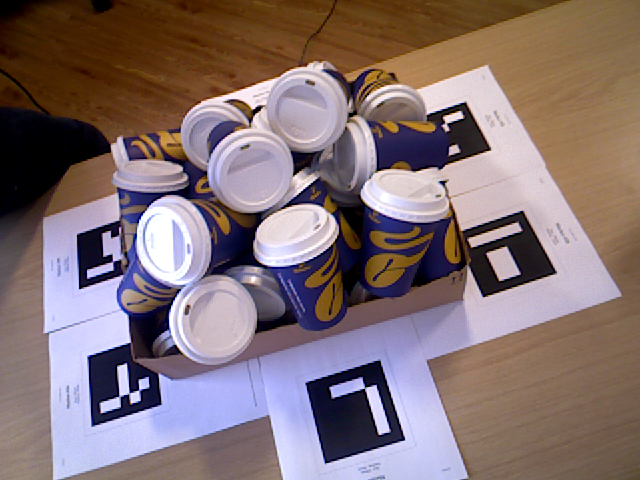

In [41]:
from PIL import Image
import torch
# rgb_path = "datasets/bop23_challenge/results/cnos_exps/visualization/sam_pbr_tless/tless000007/000413.png"
# datasets/bop23_challenge/results/cnos_exps/visualization/sam_pbr_hb/hb000003/000420.png
# datasets/bop23_challenge/results/cnos_exps/visualization/sam_pbr_icbin/icbin000001/000009.png
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000009.png"
image = Image.open(rgb_path)
image

In [42]:
import torchvision.transforms as T
inv_rgb_transform = T.Compose(
    [
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float32),  # Convert uint8 to float
        T.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        ),
    ]
)

In [43]:
import numpy as np
image_np = (
    inv_rgb_transform(image) # batch["image"][0] 0 to retrun image 3,H,W cos the batch has size of batch_size,3,W,H - where batch_size = 1
    .cpu()
    .numpy()
    .transpose(1, 2, 0)
)
image_np = np.uint8(image_np.clip(0, 1) * 255) # just get image in numpy in range of 0,255

In [44]:
proposals = custom_sam_model.generate_masks(image_np)


In [45]:
proposals["masks"][0].shape

torch.Size([480, 640])

In [46]:
import matplotlib.pyplot as plt
def matplotlib_imshow(binary_mask):
    # Convert the boolean mask to an integer mask
    binary_mask_int = binary_mask.int()

    # Convert the binary mask to a NumPy array
    binary_mask_np = binary_mask_int.cpu().numpy()

    # Plot the binary mask
    plt.imshow(binary_mask_np, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')  # Hide axis
    plt.show()

In [47]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    new_height = width * cropped_image.height // cropped_image.width
    return cropped_image.resize((width, new_height))

In [48]:
proposals["boxes"].shape

torch.Size([92, 4])

In [49]:
masked_images = []
for mask in proposals["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(image, binary_mask)
    masked_images.append(masked_image)

In [50]:
def show_anns(anns):
    if len(anns) == 0:
        return
    # sorted(anns, key=(lambda x: x['area']), reverse=True)
    sorted_anns = anns['masks'].cpu()
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0].shape[0],
                  sorted_anns[0].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = np.array(ann, dtype=bool)
        if m.mean() > 0.5:
            continue
        color_mask = np.concatenate([np.random.random(3), [0.6]])
        img[m] = color_mask
    ax.imshow(img)

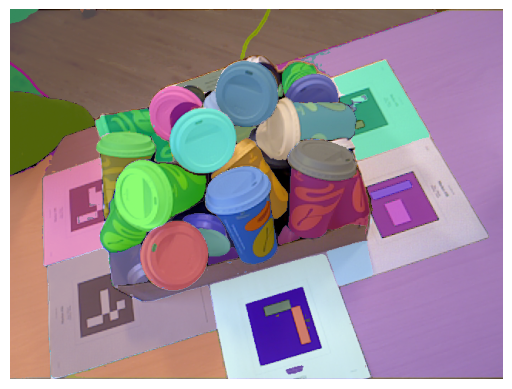

In [51]:
# SAM
plt.imshow(np.array(image))
show_anns(proposals)
plt.axis('off')
plt.show()

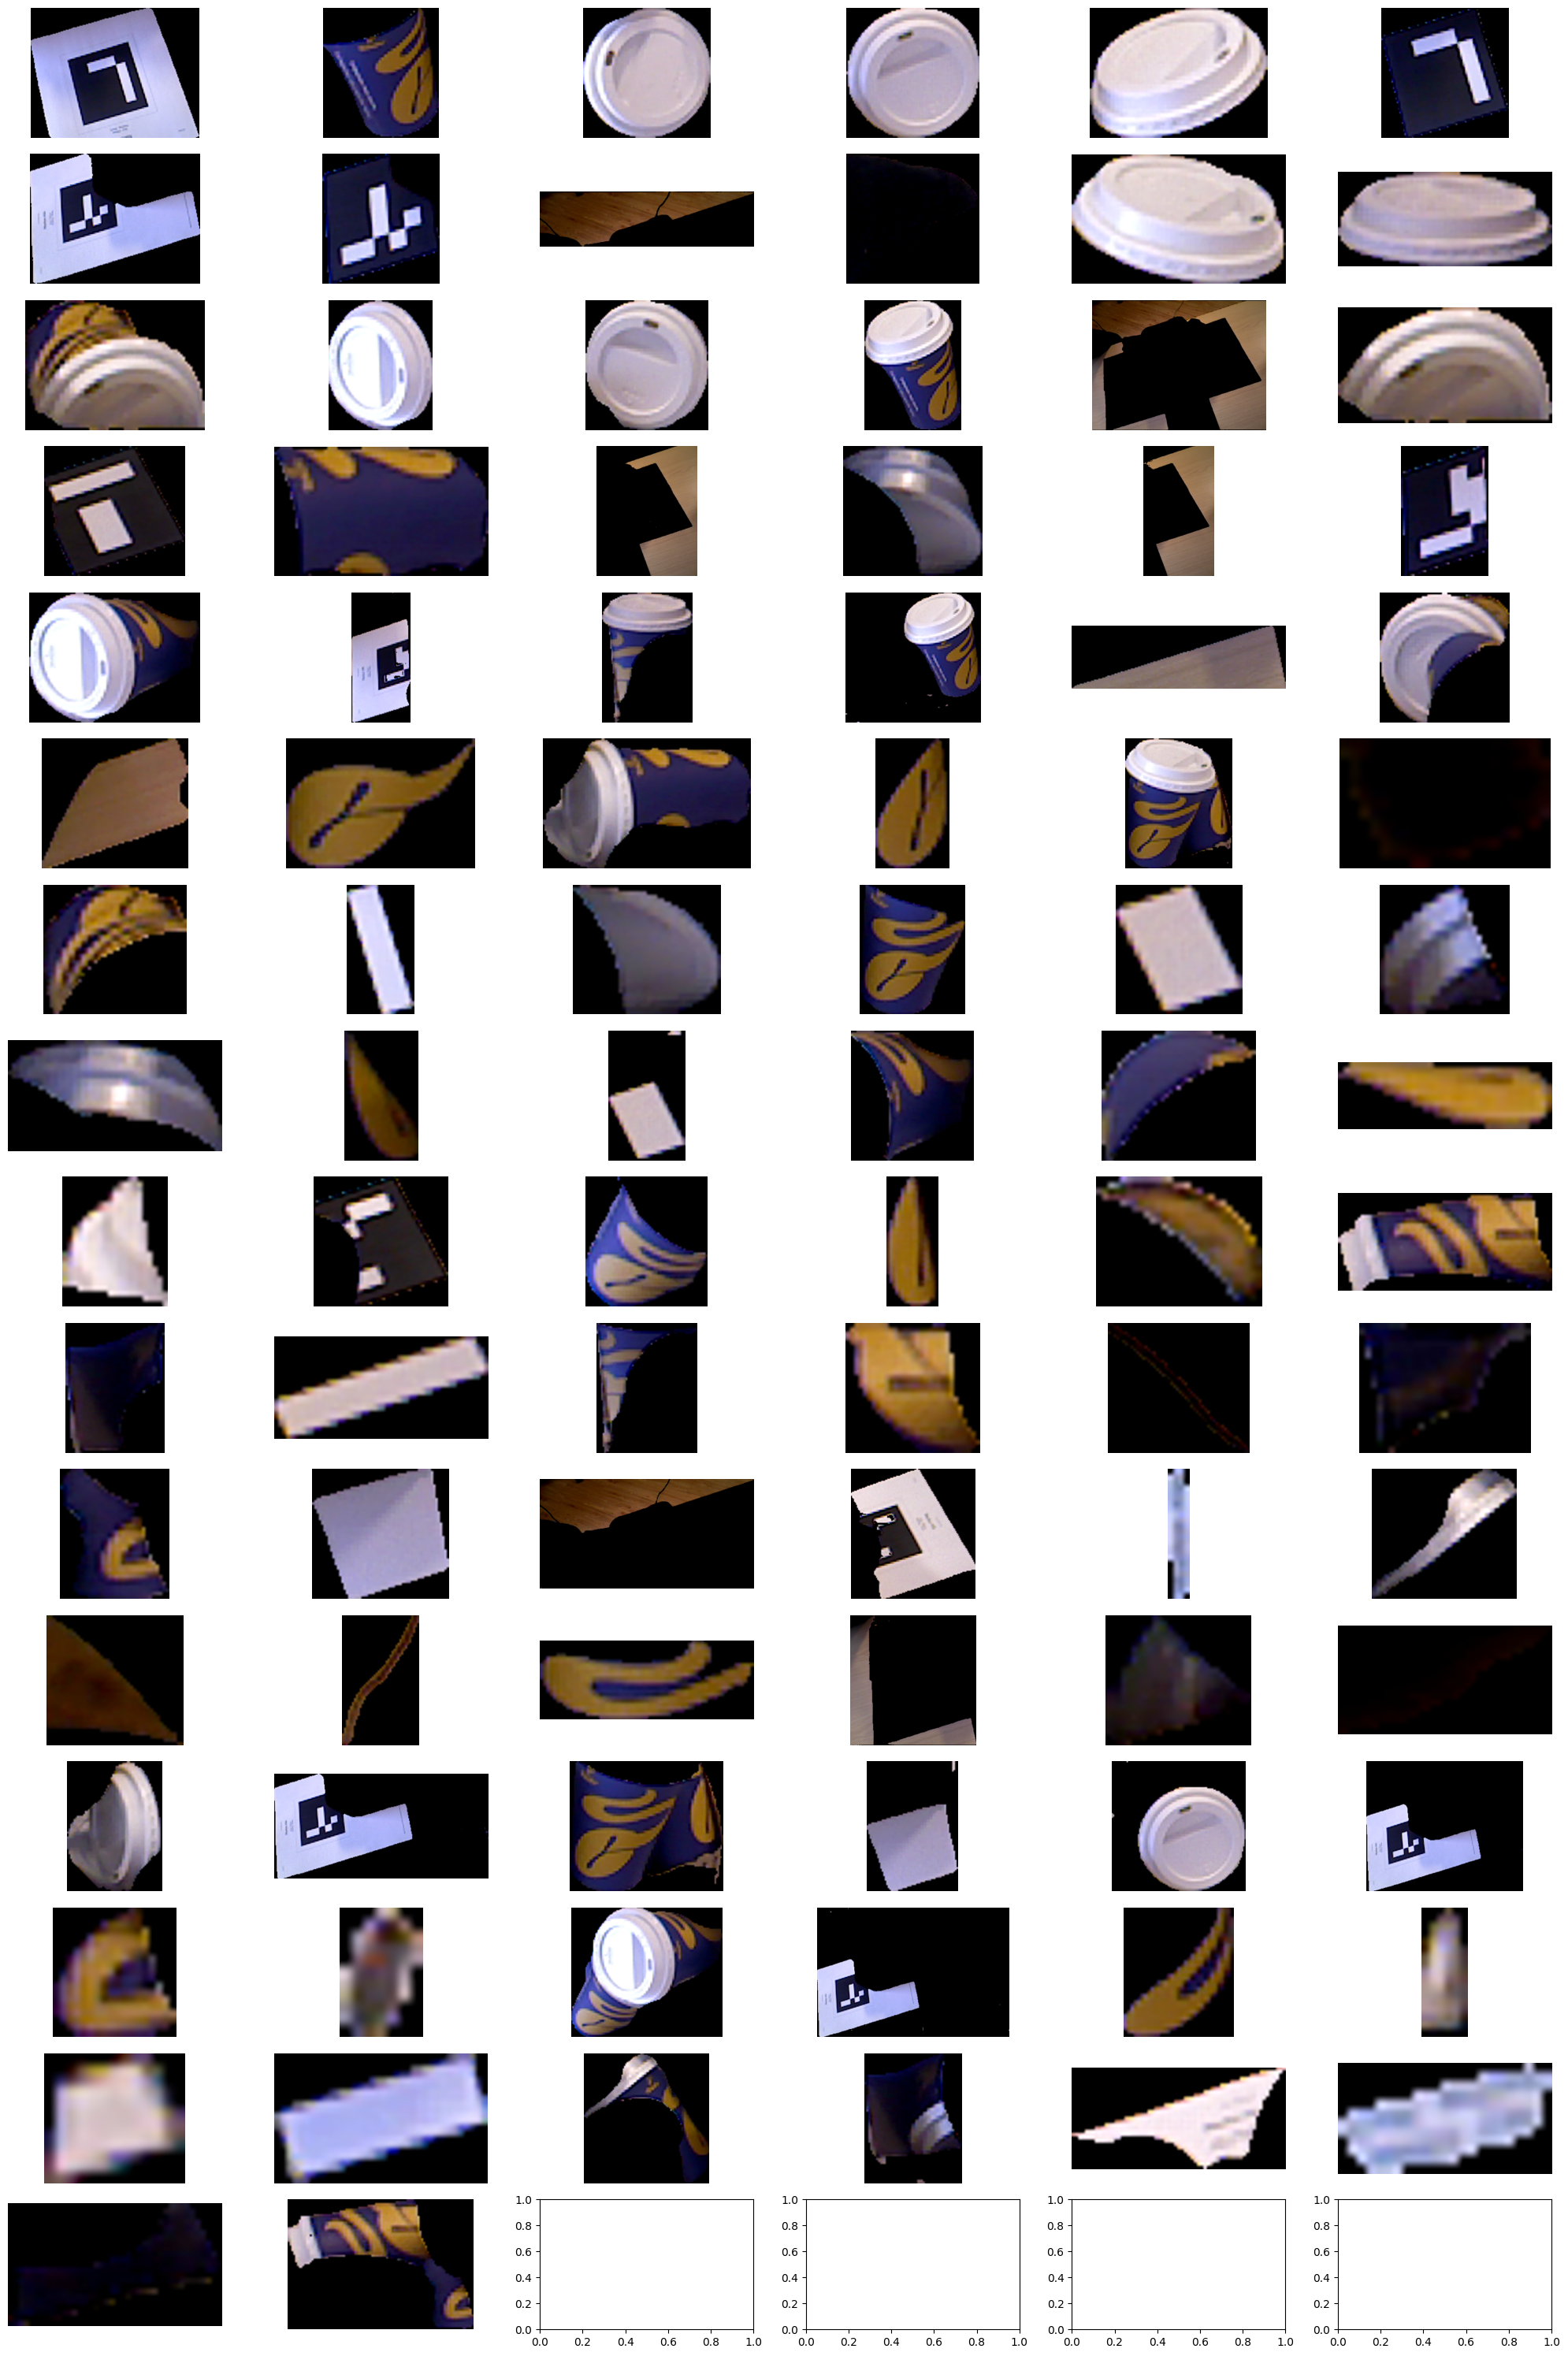

In [52]:
import matplotlib.pyplot as plt
from math import ceil


def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break

        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Define the number of rows and columns in the grid

rows = ceil(len(masked_images) / 6)
cols = 6

# Plot the masked_images array in a grid

plot_images(masked_images, rows, cols)

In [53]:
proposals["masks"].shape

torch.Size([92, 480, 640])